In [1]:
import shutup
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tsgcn.simulation import MsprimeSimulation, run_sims
from tsgcn.util import get_idle_gpu
from tsgcn.data import TreeSequenceData, TreeSequencesDataset, windowed_div_from_ts, compute_ys, get_node_features
from tsgcn.model import BiGCNModel, BiGCNEncoder

import tskit

shutup.please()

/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is depr

In [2]:
import torchvision
from torchview import draw_graph

In [3]:
import gpustat
gpustat.print_gpustat()

poppy                     Thu May 25 16:43:17 2023  525.105.17
[0] NVIDIA A100 80GB PCIe | 32°C,   0 % |  2147 / 81920 MB | murillor(1278M)
[1] NVIDIA A100 80GB PCIe | 30°C,  31 % |  2149 / 81920 MB | murillor(1280M)
[2] NVIDIA A100 80GB PCIe | 56°C, 100 % | 81277 / 81920 MB | chriscs(80408M)


In [4]:
# this device variable will get used later during training
device = torch.device(f"cuda:{get_idle_gpu()}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
## CONSTANTS
seed = 11379
num_reps = 1_000
sp_name = "HomSap"
chrom = None
length = 1_000_000
model_name ="OutOfAfrica_3G09"
sample_size=10
num_windows = 100
model_num_windows = 50
HomSap_chr13_OOA = MsprimeSimulation(seed, num_reps, sp_name, model_name, "data/raw/", chrom, length, sample_size, n_workers=512)
model_breaks = np.linspace(0, HomSap_chr13_OOA.contig.length, model_num_windows+1)
out_breaks = np.linspace(0, HomSap_chr13_OOA.contig.length, num_windows+1)

In [6]:
run_sims(HomSap_chr13_OOA)

In [7]:
# Just exploring the output of convert_tseq
from tsgcn.util import convert_tseq
ts=tskit.load(HomSap_chr13_OOA.ts_paths[0])
eix, ei, nf, sq = convert_tseq(ts)
a=TreeSequenceData(edge_index=eix, edge_interval=ei, x = nf, sequence_length=sq)

In [8]:
nf = get_node_features(ts)
nf

tensor([-0.8925, -0.8925, -0.8925,  ...,  1.8800,  1.8800,  1.8800])

In [9]:
# Importing our dataset
dataset = TreeSequencesDataset("data/", HomSap_chr13_OOA.sims_path,seeds=HomSap_chr13_OOA.seed_array, y_name="node-features")

In [10]:
compute_ys(dataset, get_node_features, "node-features", n_workers=256)

In [11]:
from torch.utils.data import random_split

torch.manual_seed(123)
train_set, valid_set, test_set = random_split(dataset,[70*dataset.len()//100, 15*dataset.len()//100, 15*dataset.len()//100])

trainloader = DataLoader(train_set, batch_size=1, shuffle=True)
validloader = DataLoader(valid_set, batch_size=1, shuffle=True)
testloader = DataLoader(test_set, batch_size=1, shuffle=True)

In [12]:
def get_y(batch):
    #return batch.x[:,0].unsqueeze(1)
    return batch.y.unsqueeze(1)

In [32]:
torch.manual_seed(1793335)
model = BiGCNModel(dataset.num_features, channels=8, num_layers=2, device=device, num_out_features=1, dropout=0.5, activation="tanh")
model = model.to(device)


In [33]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
num_epochs=60
criterion = torch.nn.MSELoss()
last_train_loss = 0

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    num_batches = 0
    for batch in trainloader:
        num_batches+=1
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        #print(output.shape, batch.x[:,0].unsqueeze(1).shape)
        loss = criterion(output,get_y(batch))
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    
    train_avg_loss = epoch_loss / num_batches
    val_loss = 0
    model.eval()
    num_batches = 0
    for batch in validloader:
        num_batches+=1
        batch.to(device)
        output = model(batch)
        loss = criterion(output,get_y(batch))
        val_loss += loss.item()
    val_avg_loss = val_loss/num_batches
    print(f"Epochs: {epoch} | epoch avg. loss: {train_avg_loss:.8f} | validation avg. loss: {val_avg_loss:.8f}")
    if abs(train_avg_loss-last_train_loss) < 1e-3 and epoch > 15: 
        print("early stopping")
        break
    last_train_loss = train_avg_loss

Epochs: 0 | epoch avg. loss: 1.61565814 | validation avg. loss: 1.01335138
Epochs: 1 | epoch avg. loss: 1.35803503 | validation avg. loss: 1.07463253
Epochs: 2 | epoch avg. loss: 1.17905068 | validation avg. loss: 1.08712401
Epochs: 3 | epoch avg. loss: 1.07357230 | validation avg. loss: 1.10160727
Epochs: 4 | epoch avg. loss: 0.97826021 | validation avg. loss: 1.11930872
Epochs: 5 | epoch avg. loss: 0.89039802 | validation avg. loss: 1.14941726
Epochs: 6 | epoch avg. loss: 0.80133496 | validation avg. loss: 1.18448944
Epochs: 7 | epoch avg. loss: 0.69692520 | validation avg. loss: 1.23048293
Epochs: 8 | epoch avg. loss: 0.62300304 | validation avg. loss: 1.25821896
Epochs: 9 | epoch avg. loss: 0.58868694 | validation avg. loss: 1.28325005
Epochs: 10 | epoch avg. loss: 0.56109812 | validation avg. loss: 1.29964875
Epochs: 11 | epoch avg. loss: 0.51901927 | validation avg. loss: 1.29490218
Epochs: 12 | epoch avg. loss: 0.49969140 | validation avg. loss: 1.29078040
Epochs: 13 | epoch avg

In [15]:
model.eval()
predictions = []
real = []

for batch in testloader:
    
    output = model(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(get_y(batch).detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

In [16]:
#torch.save(model.encoder.state_dict(), "trained_encoder.pt")

In [17]:
model.encoder

BiGCNEncoder(
  (lin): Linear(in_features=2, out_features=4, bias=True)
  (convs): ModuleList(
    (0): GCN2Conv(4, alpha=0.1, beta=0.4054651081081644)
  )
  (batch_norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [18]:
predictions.shape

(217083, 1)

In [19]:
real.shape

(217083, 1)

In [20]:
batch = next(iter(testloader))

In [21]:
batch.to(device)
output = model(batch)
criterion(output, get_y(batch))

tensor(0.9965, device='cuda:0', grad_fn=<MseLossBackward0>)

Visualizing `Predicted~Observed` diversity within a single tree sequence

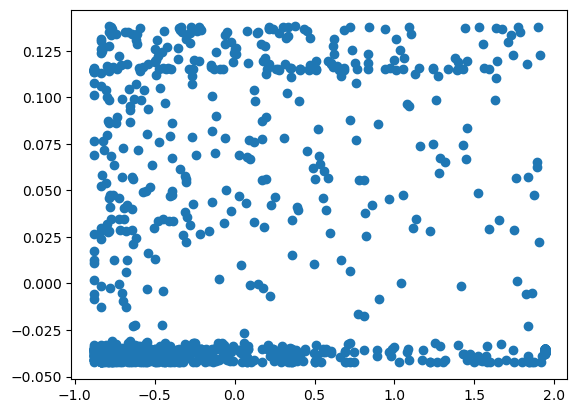

In [22]:
plt.scatter(get_y(batch).detach().cpu().numpy(), output.detach().cpu().numpy())
#plt.axline((0.5,0.5), slope=1)

Now across all windows and tree sequences

In [23]:
import scipy.stats

In [24]:
# calculate r^2 of real and predictions
scipy.stats.pearsonr(real.flatten(), predictions.flatten())[0]**2

0.005130865662893587

Text(0.5, 0, 'Observed diversity')

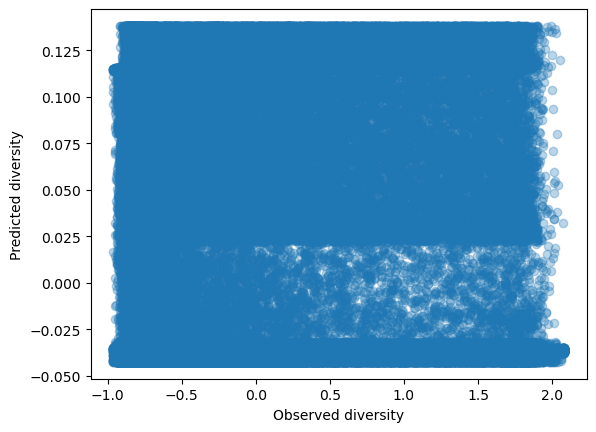

In [25]:


plt.scatter(real, predictions, alpha=0.3)
#plt.axline((0.5,0.5), slope=1)

plt.ylabel('Predicted diversity')
plt.xlabel('Observed diversity')